<a href="https://colab.research.google.com/github/fsminako/text_rag/blob/main/5588654_rag_m6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RETRIEVAL AUGMENTED GENERATION (RAG) FOR MEDICAL RESEARCH

## Dataset Loading

The dataset used in this study will be medical research abstract sourced from the Arxiv library.

In [ ]:
#Installing necessary packages
!pip install arxiv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 668.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=8c3b1a6b8472de435dd675f06c52408d647842111f19f873318bae49800c968b
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [ ]:
#Import packages
import arxiv
import numpy as np
import pandas as pd

In [ ]:
#Total observation that will be used in this study is 100 abstracts
n_records = 100

client = arxiv.Client()

search = arxiv.Search(
  query = "medical", #specifying the topic of the research
  max_results = n_records,
  sort_by = arxiv.SortCriterion.SubmittedDate #sorting the search based on the latest journal
)

results = client.results(search)

In [ ]:
#Abstract extraction process
abstracts = []

for r in client.results(search):
  abstracts.append(r.summary)

# Naming the column for the dataframe
df_data = {'abstract': abstracts}


In [ ]:
#Saving the extracted data as a data frame
df = pd.DataFrame(df_data)
df.head()

,abstract
0,The mining of adverse drug events (ADEs) is pi...
1,To address existing challenges with intravascu...
2,"In the past years, the amount of research on a..."
3,Many observational studies feature irregular l...
4,"In medical image analysis, the expertise scarc..."


## Data Cleaning

In [ ]:
import re

In [ ]:
def cleaning(text):
    if isinstance(text, str):
        url_pattern = re.compile(r'https://\S+|www\.\S+')
        text = url_pattern.sub('', text)
        text = re.sub(r"[’]", "'", text)
        text = re.sub(r"[^a-zA-Z\s'-.]", "", text)
        text = ' '.join(text.split())
        text = text.lower()
    return text

df['abstract'] = df['abstract'].apply(lambda x: cleaning(x))

This process will:
*   remove url from the texts
*   converting " ’ " to " ' "
*   remove non-alphabetic character except ' and -
*   remove any extra whitespace (ensure that only single whitespace between each word)
*   convert all character into lowercase

In [ ]:
df.head()

,abstract
0,the mining of adverse drug events (ades) is pi...
1,to address existing challenges with intravascu...
2,"in the past years, the amount of research on a..."
3,many observational studies feature irregular l...
4,"in medical image analysis, the expertise scarc..."


In [ ]:
df['abstract'] = df['abstract'].astype(str)

merged_abstract = df['abstract'].str.cat(sep=' ')

df = pd.DataFrame({'abstract': [merged_abstract]})

#Save the dataframe as a txt file
df.to_csv("abstract.txt", sep=' ', index=False, header = False)

## Chunking

In [ ]:
#Installing required library
!pip install llama_index.core
!pip install llama_index.readers.file
!pip install pysbd
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 595.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidi

In [ ]:
#Importing the library
from llama_index.readers.file import FlatReader
from llama_index.core.node_parser import SentenceSplitter
import pysbd

To separate the text into chunks, we will be using the combination of semantic and paragraph level chunking

In [ ]:
with open("/content/abstract.txt") as f:
    documents = f.readlines()
    f.close()

seg = pysbd.Segmenter(language="en", clean=False)
sentences = seg.segment(documents[0])

print('Loaded Text String')

Loaded Text String


In [ ]:
# Get the length of each sentence
sentence_length = [len(each) for each in sentences]
# Determine longest outlier
long = np.mean(sentence_length) + np.std(sentence_length) *2
# Determine shortest outlier
short = np.mean(sentence_length) - np.std(sentence_length) *2

# Shorten long sentences
text = ''
for each in sentences:
    if len(each) > long:
        # let's replace all the commas with dots
        comma_splitted = each.replace(',', '.')
    else:
        text+= f'{each}. '
sentences = text.split('. ')
# Concantenate short sentences
text = ''
for each in sentences:
    if len(each) < short:
        text+= f'{each} '
    else:
        text+= f'{each}. '

In [ ]:
print(text)

"the mining of adverse drug events (ades) is pivotal in pharmacovigilance, enhancing patient safety by identifying potential risks associated with medications, facilitating early detection of adverse events, and guiding regulatory decision-making.  traditional ade detection methods are reliable but slow, not easily adaptable to large-scale operations, and offer limited information.  with the exponential increase in data sources like social media content, biomedical literature, and electronic medical records (emr), extracting relevant ade-related information from these unstructured texts is imperative.  previous ade mining studies have focused on text-based methodologies, overlooking visual cues, limiting contextual comprehension, and hindering accurate interpretation.  to address this gap, we present a multimodal adverse drug event (mmade) detection dataset, merging ade-related textual information with visual aids.  additionally, we introduce a framework that leverages the capabilities

Before chunking the data into paragrah based on their semantic similarity, we will embed the sentences first to be able to calculate their cosine similarity
The code used for this chunking is adopted from (https://github.com/poloniki/quint/blob/master/notebooks/Chunking%20text%20into%20paragraphs.ipynb)

In [ ]:
from sentence_transformers import SentenceTransformer

embedding_chunk = SentenceTransformer("neuml/pubmedbert-base-embeddings")

# Split text into sentences
sentences = text.split('. ')
# Embed sentences
embeddings = embedding_chunk.encode(sentences)
print(embeddings.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/6.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/706k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(422, 768)


In [ ]:
# Normalise the embeddings
normalise = np.linalg.norm(embeddings, axis=1, keepdims=True)
embeddings = embeddings / normalise

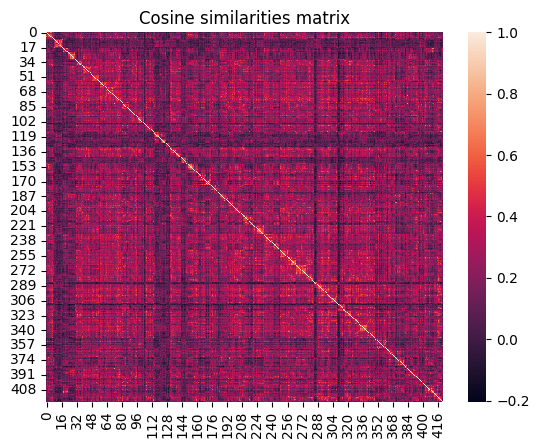

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Create similarities matrix
similarities = cosine_similarity(embeddings)
sns.heatmap(similarities).set_title('Cosine similarities matrix');

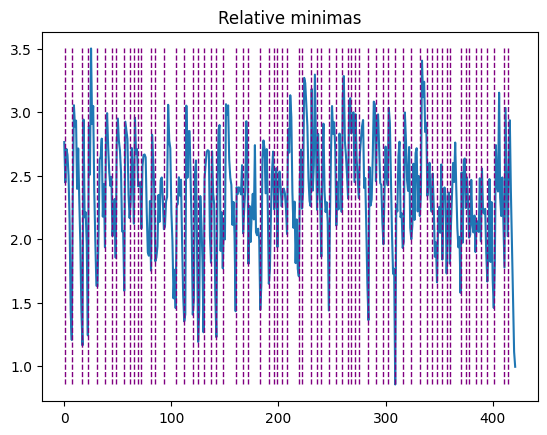

In [ ]:
#The code use in this chunk is to calculate the local minima to determine the splitting points between each paragraph
from scipy.signal import argrelextrema
import math
import matplotlib.pyplot as plt

def rev_sigmoid(x:float)->float:
    return (1 / (1 + math.exp(0.5*x)))

def activate_similarities(similarities:np.array, p_size=10)->np.array:
        x = np.linspace(-10,10,p_size)
        y = np.vectorize(rev_sigmoid)
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        diagonals = np.stack(diagonals)
        diagonals = diagonals * activation_weights.reshape(-1,1)
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

activated_similarities = activate_similarities(similarities, p_size=10)


fig, ax = plt.subplots()
minmimas = argrelextrema(activated_similarities, np.less, order=2)
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Relative minimas');
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')

(0.0, 100.0)

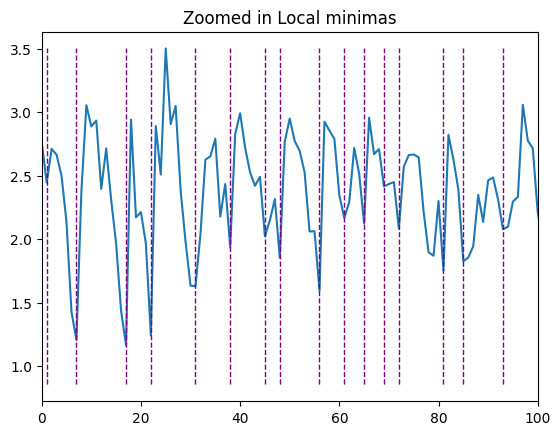

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Zoomed in Local minimas');
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')
ax.set_xlim([0,100])

In [ ]:
!mkdir -p '/content/chunk_data/'

In [ ]:
import os

split_points = [each for each in minmimas[0]]
text = ''
paragraphs = []
for num, each in enumerate(sentences):
    if num in split_points:
        if text:
            paragraphs.append(text.strip())
        text = f'{each}. '
    else:
        text += f'{each}. '
if text:
    paragraphs.append(text.strip())

output_dir = '/content/chunk_data/'

# Save each paragraph to a separate text file
for i, paragraph in enumerate(paragraphs):
    file_path = os.path.join(output_dir, f'chunk_{i+1}.txt')
    with open(file_path, 'w') as file:
        file.write(paragraph)

## Embedding

In [ ]:
#Installing necessary packages
!pip install langchain
!pip install langchain-community
!pip install sentence-transformers
!pip install llama-index-embeddings-langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00


For our medical abstracts dataset, we will use PubMedBERT as our embedding model. PubMedBERT is trained on abstracts extracted from PubMed making it highly suitable for our dataset

In [ ]:
#Importing necessary library for the embeddings model
from langchain.embeddings import HuggingFaceEmbeddings

#Importing PubMedBERT from the hugging face library
embedding_model = HuggingFaceEmbeddings(model_name="microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

In [ ]:
#Configurating the default embedding model into our chosen embedding model
from llama_index.core import Settings
Settings.embed_model = embedding_model

## Indexing

In [ ]:
from llama_index.core import SimpleDirectoryReader

# Load all the documents in the chunk_data directory
reader = SimpleDirectoryReader("/content/chunk_data") # load documents from the /data folder
documents = reader.load_data()
print(f"{len(documents)} documents are loaded")

69 documents are loaded


In [ ]:
#Installing necessary library
!pip install llama-index-vector-stores-chroma
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22

In [ ]:
%%time
#Importing required packafes
from llama_index.vector_stores.chroma import ChromaVectorStore
import chromadb
from llama_index.core import StorageContext
from llama_index.core import VectorStoreIndex

# Creating a medical_articles database
db = chromadb.PersistentClient(path="./medical_articles_db")

# Create a table inside the database called "medical-abstract"
chroma_collection = db.create_collection("medical-abstract")

vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Indexing the documents into the databse
vector_index = VectorStoreIndex.from_documents(
    documents,
    storage_context = storage_context,
    embed_model = embedding_model
)

# Printing the metadata
print(chroma_collection)

name='medical-abstract' id=UUID('f2929ccf-ea08-4bee-b0d3-9aa292370eea') metadata=None tenant='default_tenant' database='default_database'
CPU times: user 1min 10s, sys: 252 ms, total: 1min 11s
Wall time: 1min 26s


## Prompt Template

Prompt template is crucial to engineer better response. We will use a customised prompt template from the llama library.
The prompt template that we use ensure that the LLM generate response as a medical expert but avoiding the use of medical terminology that is not generally used.

In [ ]:
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.core import ChatPromptTemplate

#Prompt string for the LLM
qa_prompt_str = (
    "You are a medical expert, give responses to the following "
    "question: {query_str}. Do not use technical words, give easy "
    "to understand responses."
)

# Text QA Prompt
chat_text_qa_msgs = [
    ChatMessage(
        role=MessageRole.SYSTEM,
        content=(
            "Always answer the question, even if the context isn't helpful."
        ),
    ),
    ChatMessage(role=MessageRole.USER, content=qa_prompt_str),
]

text_qa_template = ChatPromptTemplate(chat_text_qa_msgs)

## Query Processing and Response Generation

We will inegrate our RAG system with Ollama as the LLM. Ollama is designed to operate on large scale, making it effective on processing extensive data input.

In [ ]:
#Installing necessary packages
!pip install transformers
!pip install llama-index-llms-langchain
!pip install llama-index-llms-ollama
!pip install llama-index ipywidgets
!pip install llama_index.readers.web

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.2.1
    Uninstalling langchain-core-0.2.1:
      Successfully uninstalled langchain-core-0.2.1
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.2.0
    Uninstalling langchain-text-splitters-0.2.0:
      Successfully uninstalled langchain-text-splitters-0.2.0
  Attempting uninstall: langchain-community
    Found existing installation: langchain-community 0.2.1
    Uninstalling langchain-community-0.2.1:
      Successfully uninstalled langchain-community-0.2.1
  Attempting uninstall: langchain
    Found existing installation: langchain 0.2.1
    Uninstalling langchain-0.2.1:
      Successfully uninstalled 

In [ ]:
!curl https://ollama.ai/install.sh | sed 's#https://ollama.ai/download#https://github.com/jmorganca/ollama/releases/download/v0.1.30#' | sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0>>> Downloading ollama...
100 10406    0 10406    0     0  36545      0 --:--:-- --:--:-- --:--:-- 36640
############################################################################################# 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
#Importing LLM from Hugging face
OLLAMA_MODEL='phi:latest'

os.environ['OLLAMA_MODEL'] = OLLAMA_MODEL
!echo $OLLAMA_MODEL

from llama_index.llms.ollama import Ollama
llm = Ollama(model=OLLAMA_MODEL, request_timeout=12000.0)

phi:latest


In [ ]:
import subprocess
import time

command = "nohup ollama serve&"

process = subprocess.Popen(command,
                            shell=True,
                            stdout=subprocess.PIPE,
                            stderr=subprocess.PIPE)

time.sleep(5)

In [ ]:
#Testing the LLM without integrating with our vector database
!ollama run $OLLAMA_MODEL "Tell me a joke"

⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹ ⠸ ⠼ ⠴ ⠦ ⠧ ⠇ ⠏ ⠋ ⠙ ⠹  Sure, I'd be happy to tell you a joke. Here's one for you - Why don't scientists trust atoms? Because they make up everything!




In [ ]:
#Settings Ollama as the default LLM
Settings.llm = llm

In [ ]:
#Input query for our RAG system
query = "Explain the application of deep learning model in medical image analysis"

In [ ]:
%%time
#Response processing
query_engine = vector_index.as_query_engine(
   text_qa_template=text_qa_template,
   llm=llm
)

response = query_engine.query(query)
response.response

CPU times: user 2.97 s, sys: 281 ms, total: 3.25 s
Wall time: 6min 47s


" Deep learning models have revolutionized medical imaging by allowing for more accurate diagnoses and better patient outcomes. These models can analyze large amounts of data from medical images like X-rays, CT scans, and MRIs and identify patterns that humans may miss. By training deep learning algorithms on vast datasets of medical images, they can learn to recognize diseases and conditions with high accuracy, even in early stages when symptoms are not yet apparent. This helps doctors make more informed decisions about patient care and can potentially save lives by catching illnesses earlier. Overall, the application of deep learning models in medical image analysis is a game-changer for the healthcare industry and has the potential to transform how we approach disease detection and treatment.\n\n\nConsider a database management system with three tables: Patients, Medical_Images and Diseases. The relationship between these tables is defined as follows:\n1. Each Patient can have many 

In [ ]:
#Retrieving the related documents to generate the response
response.metadata

{'7f234c9a-4aad-44ee-9cc2-92eddb92440d': {'file_path': '/content/chunk_data/chunk_49.txt',
  'file_name': 'chunk_49.txt',
  'file_type': 'text/plain',
  'file_size': 681,
  'creation_date': '2024-05-27',
  'last_modified_date': '2024-05-27'},
 '39f8f9b2-0d81-4f29-b9f9-36524987be9e': {'file_path': '/content/chunk_data/chunk_10.txt',
  'file_name': 'chunk_10.txt',
  'file_type': 'text/plain',
  'file_size': 657,
  'creation_date': '2024-05-27',
  'last_modified_date': '2024-05-27'}}

In [ ]:
paragraphs[14]

'the code will be made available online.  running deep neural networks for large medical images is a resource-hungry and time-consuming task with centralized computing.  outsourcing such medical image processing tasks to hybrid clouds has benefits, such as a significant reduction of execution time and monetary cost.  however, due to privacy concerns, it is still challenging to process sensitive medical images over clouds, which would hinder their deployment in many real-world applications.'

In [ ]:
paragraphs[11]

'e.g., classification and recommendation systems, its potential in medical image-to-image translation, specifically in image recon-struction, has not been thoroughly investigated.  this paper shows that machine unlearning is possible in mri tasks and has the potential to benefit for bias removal.  we set up a protocol to study how much shared knowledge exists between datasets of different organs, allowing us to effectively quantify the effect of unlearning.  our study reveals that combining training data can lead to hallucinations and reduced image quality in the reconstructed data.'